# Preparing the inputs for the IN scenarios

The input files include:

1. Zone centroids shp, zone capacity csv
2. Charging station shp. charging station csv
3. Road network (already prepared)
4. Demand (need further thoughts)

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

## Zone centroid map

In [13]:
df_zone = gpd.read_file("zone/tl_2021_18_tract.shp")

In [15]:
df_zone_centroid = df_zone.copy()
df_zone_centroid['geometry'] = df_zone_centroid['geometry'].centroid

C:\Users\ALei\AppData\Local\Temp\ipykernel_45872\3623400761.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_zone_centroid['geometry'] = df_zone_centroid['geometry'].centroid


<Axes: >

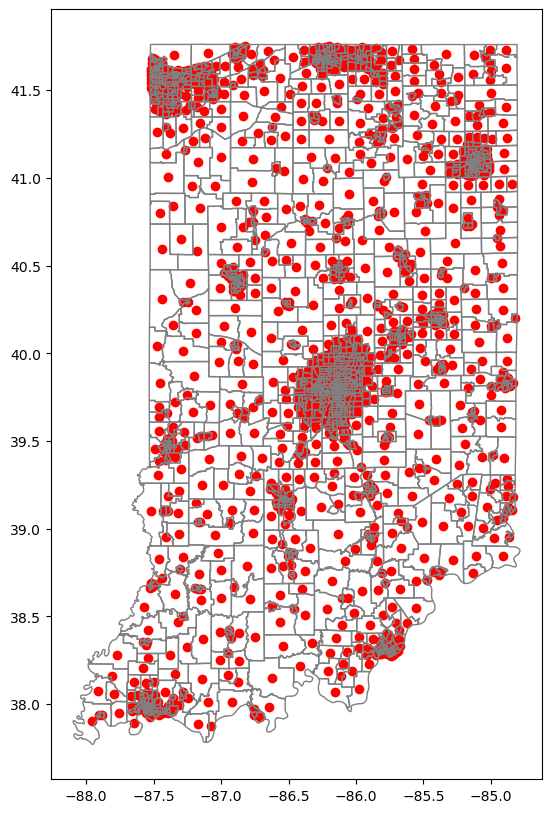

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

df_zone_centroid.plot(ax = ax, color='red')
df_zone.plot(ax = ax, facecolor='none', edgecolor='grey')

In [16]:
# save the centroids to a new file
df_zone_centroid.to_file("zone/tl_2021_18_tract_centroid.shp")

In [17]:
df_zone_centroid = df_zone_centroid[['NAME', 'GEOID']].reset_index(drop=True)
df_zone_centroid['CAPACITY'] = -1

df_zone_centroid.to_csv("zone/tl_2021_18_tract_centroid.csv", index=False)

In [18]:
df_zone_centroid.head()

,NAME,GEOID,CAPACITY
0,12,18163001200,-1
1,104,18157010400,-1
2,1,18157000100,-1
3,3507,18097350700,-1
4,23.01,18035002301,-1


# Charging station map

In [24]:
df_charging_station = gpd.read_file("charging station/indiana_alt_fuel_stations (Feb 25 2024)_filtered.geojson")

<Axes: >

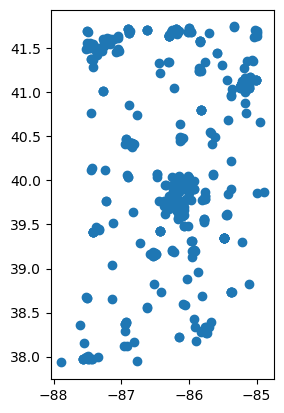

In [25]:
df_charging_station.plot()

In [26]:
df_charging_station.columns

Index(['Fuel Type Code', 'Station Name', 'Street Address',
       'Intersection Directions', 'City', 'State', 'ZIP', 'Plus4',
       'Station Phone', 'Status Code', 'Expected Date',
       'Groups With Access Code', 'Access Days Time', 'Cards Accepted',
       'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network',
       'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude',
       'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code',
       'Federal Agency ID', 'Federal Agency Name', 'Open Date',
       'EV Connector Types', 'Country', 'Access Code', 'Access Detail Code',
       'Federal Agency Code', 'Facility Type', 'EV Pricing',
       'EV On-Site Renewable Source', 'Restricted Access', 'NPS Unit Name',
       'Maximum Vehicle Class', 'EV Workplace Charging', 'geometry'],
      dtype='object')

In [27]:
# save the charging station to shp file
df_charging_station = df_charging_station[['ID', 'Fuel Type Code', 'Station Name', 'Street Address', 'City', 'State', 'ZIP', 'Latitude', 'Longitude', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'geometry']].reset_index()
df_charging_station.to_file("charging station/IN_charging_station_202402.shp")

C:\Users\ALei\AppData\Local\Temp\ipykernel_93680\2549821613.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_charging_station.to_file("charging station/IN_charging_station_202402.shp")


In [29]:
df_charging_station.drop(columns=['geometry']).to_csv("charging station/IN_charging_station_202402.csv", index=False)

# Demand file

In [3]:
df_gv = pd.read_csv("demand/gv_trips.csv")
df_ev = pd.read_csv("demand/ev_trips.csv")

In [4]:
print(len(df_gv))

316049


In [5]:
print(len(df_ev))

8751


In [6]:
# Get the integer vid from ev and gv data
df_vid = pd.concat([df_gv[['uid']], df_ev[['uid']]]).drop_duplicates().reset_index(drop=True)
df_vid['vid'] = df_vid.index

# store it to a file
df_vid.to_csv("demand/vid.csv", index=False)

In [7]:
df_gv.head()

,Unnamed: 0,uid,origin_GEOID,destination_GEOID,departure_datetime
0,0,gvd10_000a044887df5c9da34b1f8e932850b8,18057110820,18057110807,2022-10-10 19:12:21
1,1,gvd10_000a044887df5c9da34b1f8e932850b8,18057110807,18057110810,2022-10-10 19:14:21
2,2,gvd10_0025bf7b44085e67a5ce6b38d03944c1,18097330103,18057110815,2022-10-10 12:46:41
3,3,gvd10_005f0ed7c86252f0b434891cc6117645,18081610605,18081610606,2022-10-10 19:02:45
4,4,gvd10_007ed48f3cb758d8a02ff93ec821d502,18097330210,18097330212,2022-10-10 18:46:39


In [8]:
df_zone = pd.read_csv("zone/tl_2021_18_tract_centroid.csv")

df_zone['zone_id'] = df_zone.index

In [9]:
df_zone

,NAME,GEOID,CAPACITY,zone_id
0,12.00,18163001200,-1,0
1,104.00,18157010400,-1,1
2,1.00,18157000100,-1,2
3,3507.00,18097350700,-1,3
4,23.01,18035002301,-1,4
...,...,...,...,...
1691,9674.00,18175967400,-1,1691
1692,21.00,18003002100,-1,1692
1693,3812.03,18097381203,-1,1693
1694,3812.04,18097381204,-1,1694


In [10]:
# make the demand data into a csv file by transform the uid into vid, TRACTCE into zone_id, departure time into minutes of the day
df_gv = pd.merge(df_gv, df_vid, left_on='uid', right_on='uid', how='left')
df_gv = pd.merge(df_gv, df_zone[['GEOID', 'zone_id']], left_on='origin_GEOID', right_on='GEOID', how='left')
df_gv = pd.merge(df_gv, df_zone[['GEOID', 'zone_id']], left_on='destination_GEOID', right_on='GEOID', how='left')

df_gv['departure_datetime'] = pd.to_datetime(df_gv['departure_datetime'])

df_ev = pd.merge(df_ev, df_vid, left_on='uid', right_on='uid', how='left')
df_ev = pd.merge(df_ev, df_zone[['GEOID', 'zone_id']], left_on='origin_GEOID', right_on='GEOID', how='left')
df_ev = pd.merge(df_ev, df_zone[['GEOID', 'zone_id']], left_on='destination_GEOID', right_on='GEOID', how='left')

df_ev['departure_datetime'] = pd.to_datetime(df_ev['departure_datetime'])

In [11]:
start_time = pd.Timestamp('2022-10-02 0:00:00')

<Axes: xlabel='hour'>

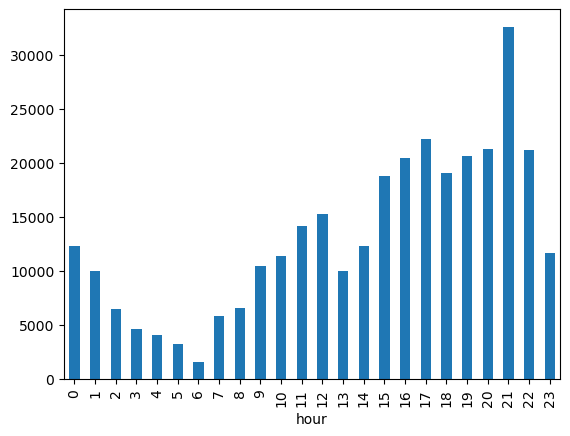

In [49]:
# visualize hourly demand from starting time in bar plots
fig, ax = plt.subplots(figsize=(10, 6))

df_ev['hour'] = (df_ev['departure_datetime'] - start_time).dt.total_seconds() // 3600


In [27]:
df_gv['departure_datetime'].min()

Timestamp('2022-10-02 02:03:27')

In [28]:
df_gv['departure_datetime'].sort_values()

225789   2022-10-02 02:03:27
226550   2022-10-02 02:35:02
226117   2022-10-02 02:46:37
226812   2022-10-02 02:47:20
226793   2022-10-02 02:47:58
                 ...        
219364   2022-10-14 18:48:36
198343   2022-10-14 18:52:07
205841   2022-10-14 18:52:17
209870   2022-10-14 18:52:35
170346   2022-10-14 18:53:33
Name: departure_datetime, Length: 316049, dtype: datetime64[ns]

In [29]:
df_ev['departure_datetime'].sort_values()

4121   2022-10-02 15:38:01
4122   2022-10-02 15:38:32
4139   2022-10-02 15:38:49
4140   2022-10-02 15:39:19
4123   2022-10-02 15:40:31
               ...        
3343   2022-10-14 18:50:06
2694   2022-10-14 18:50:46
2695   2022-10-14 18:53:16
4037   2022-10-14 18:55:06
4038   2022-10-14 18:56:06
Name: departure_datetime, Length: 8751, dtype: datetime64[ns]

In [30]:
start_time = pd.Timestamp('2022-10-02 21:00:00')
end_time = pd.Timestamp('2022-10-14 03:00:00')

In [31]:
# filter the data within start time and end time, get the minutes from the start time
df_gv = df_gv[(df_gv['departure_datetime'] >= start_time) & (df_gv['departure_datetime'] <= end_time)]
df_gv['minutes'] = (df_gv['departure_datetime'] - start_time).dt.total_seconds() // 60

df_ev = df_ev[(df_ev['departure_datetime'] >= start_time) & (df_ev['departure_datetime'] <= end_time)]
df_ev['minutes'] = (df_ev['departure_datetime'] - start_time).dt.total_seconds() // 60

In [32]:
df_gv

,Unnamed: 0,uid,origin_GEOID,destination_GEOID,departure_datetime,vid,GEOID_x,zone_id_x,GEOID_y,zone_id_y,minutes
0,0,gvd10_000a044887df5c9da34b1f8e932850b8,18057110820,18057110807,2022-10-10 19:12:21,0,18057110820,1169,18057110807,261,11412.0
1,1,gvd10_000a044887df5c9da34b1f8e932850b8,18057110807,18057110810,2022-10-10 19:14:21,0,18057110807,261,18057110810,262,11414.0
2,2,gvd10_0025bf7b44085e67a5ce6b38d03944c1,18097330103,18057110815,2022-10-10 12:46:41,1,18097330103,228,18057110815,790,11026.0
3,3,gvd10_005f0ed7c86252f0b434891cc6117645,18081610605,18081610606,2022-10-10 19:02:45,2,18081610605,444,18081610606,126,11402.0
4,4,gvd10_007ed48f3cb758d8a02ff93ec821d502,18097330210,18097330212,2022-10-10 18:46:39,3,18097330210,1089,18097330212,1099,11386.0
...,...,...,...,...,...,...,...,...,...,...,...
316044,316044,gvd9_ffae328fb51d52c2a80ee708e740ad94,18091040900,18091040500,2022-10-09 02:41:39,42514,18091040900,26,18091040500,76,8981.0
316045,316045,gvd9_ffaee6ee36a65d008b77047a19e35b01,18089012400,18089043204,2022-10-09 01:34:59,42515,18089012400,1418,18089043204,334,8914.0
316046,316046,gvd9_ffaee6ee36a65d008b77047a19e35b01,18089043204,18089043104,2022-10-09 01:51:43,42515,18089043204,334,18089043104,353,8931.0
316047,316047,gvd9_fff02e19013655e2885250101683dda6,18057110904,18057110907,2022-10-09 07:14:50,42516,18057110904,158,18057110907,157,9254.0


In [33]:
# store the vid, minutes, zone_id_x, zone_id_y in a new file, rename the columns as vid, time_ind, origin, destination
df_gv = df_gv[['vid', 'minutes', 'zone_id_x', 'zone_id_y']].rename(columns={'zone_id_x': 'origin', 'zone_id_y': 'destination', 'minutes': 'time_ind'})


df_ev = df_ev[['vid', 'minutes', 'zone_id_x', 'zone_id_y']].rename(columns={'zone_id_x': 'origin', 'zone_id_y': 'destination', 'minutes': 'time_ind'})


In [35]:
df_gv

,vid,time_ind,origin,destination
0,0,11412.0,1169,261
1,0,11414.0,261,262
2,1,11026.0,228,790
3,2,11402.0,444,126
4,3,11386.0,1089,1099
...,...,...,...,...
316044,42514,8981.0,26,76
316045,42515,8914.0,1418,334
316046,42515,8931.0,334,353
316047,42516,9254.0,158,157


In [34]:
df_ev

,vid,time_ind,origin,destination
0,42517,10260.0,291,869
1,42517,10261.0,869,291
2,42518,11439.0,96,1020
3,42518,11440.0,1020,96
4,42518,11440.0,96,1020
...,...,...,...,...
8746,43262,10002.0,63,1510
8747,43262,10002.0,1510,427
8748,43262,10003.0,427,1045
8749,43262,10005.0,1045,412


In [38]:
# sort the time_ind in ascending order, parse time_ind into integer
df_gv['time_ind'] = df_gv['time_ind'].astype(int)
df_ev['time_ind'] = df_ev['time_ind'].astype(int)
df_gv = df_gv.sort_values(by=['time_ind'])
df_ev = df_ev.sort_values(by=['time_ind'])

In [65]:
df_gv

,Unnamed: 0,uid,origin_TRACTCE,destination_TRACTCE,departure_datetime,vid,TRACTCE_x,zone_id_x,TRACTCE_y,zone_id_y,minutes,time_ind
1387790,227164,gvd3_f1fe73a29c3e5f08badb7916ee0d3aa0,352600,10700,2022-10-03 09:36:12,26952,352600,459,10700,1257,756.0,756
1387788,227164,gvd3_f1fe73a29c3e5f08badb7916ee0d3aa0,352600,10700,2022-10-03 09:36:12,26952,352600,459,10700,178,756.0,756
1387789,227164,gvd3_f1fe73a29c3e5f08badb7916ee0d3aa0,352600,10700,2022-10-03 09:36:12,26952,352600,459,10700,621,756.0,756
1387791,227164,gvd3_f1fe73a29c3e5f08badb7916ee0d3aa0,352600,10700,2022-10-03 09:36:12,26952,352600,459,10700,1359,756.0,756
1387792,227164,gvd3_f1fe73a29c3e5f08badb7916ee0d3aa0,352600,10700,2022-10-03 09:36:12,26952,352600,459,10700,1495,756.0,756
...,...,...,...,...,...,...,...,...,...,...,...,...
1209366,200361,gvd14_a5c6b0208fa15826af168a643a8c7eea,11605,2200,2022-10-14 02:59:11,23331,11605,502,2200,1167,16199.0,16199
974873,161231,gvd14_1e5a38eb3dcf52db874a3d02fa4a1d82,41400,41600,2022-10-14 02:59:40,18909,41400,17,41600,78,16199.0,16199
974874,161231,gvd14_1e5a38eb3dcf52db874a3d02fa4a1d82,41400,41600,2022-10-14 02:59:40,18909,41400,17,41600,739,16199.0,16199
1018163,168347,gvd14_37758fc47d9152b4bdda72db16f7327e,30707,30300,2022-10-14 02:59:10,19731,30707,654,30300,1371,16199.0,16199


In [66]:
df_ev

,Unnamed: 0,uid,origin_TRACTCE,destination_TRACTCE,departure_datetime,vid,TRACTCE_x,zone_id_x,TRACTCE_y,zone_id_y,minutes,time_ind
31876,4162,evd3_6de354e4caf8547fa24a721b823f1fae,5401,11200,2022-10-03 11:03:49,42868,5401,1292,11200,1655,843.0,843
31875,4162,evd3_6de354e4caf8547fa24a721b823f1fae,5401,11200,2022-10-03 11:03:49,42868,5401,1292,11200,1290,843.0,843
31874,4162,evd3_6de354e4caf8547fa24a721b823f1fae,5401,11200,2022-10-03 11:03:49,42868,5401,1292,11200,727,843.0,843
31873,4162,evd3_6de354e4caf8547fa24a721b823f1fae,5401,11200,2022-10-03 11:03:49,42868,5401,1292,11200,173,843.0,843
31880,4163,evd3_6de354e4caf8547fa24a721b823f1fae,11200,5401,2022-10-03 11:06:50,42868,11200,1655,5401,1292,846.0,846
...,...,...,...,...,...,...,...,...,...,...,...,...
19606,2841,evd14_29d01bd36c20552ba529fa07d2e39825,380403,380404,2022-10-14 02:57:42,42763,380403,1589,380404,1587,16197.0,16197
26705,3512,evd14_882174f3681a589db25108ccf1ecaacc,1300,1000,2022-10-14 02:57:13,42808,1300,537,1000,1155,16197.0,16197
26708,3512,evd14_882174f3681a589db25108ccf1ecaacc,1300,1000,2022-10-14 02:57:13,42808,1300,736,1000,122,16197.0,16197
19608,2843,evd14_29d01bd36c20552ba529fa07d2e39825,380502,380600,2022-10-14 02:58:43,42763,380502,48,380600,423,16198.0,16198


In [40]:
df_gv.reset_index(drop=True).to_csv("demand/gv_trip_demand.csv", index=False)
df_ev.reset_index(drop=True).to_csv("demand/ev_trip_demand.csv", index=False)